In [3]:
import sys
sys.path.append('../')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers_mom6.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [10]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [11]:
directory = "/scratch/pp2681/mom6/Apr2023/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [12]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/GZ21_results', additional_subfolder='')

In [14]:
directory = "/scratch/pp2681/mom6/CM26_Double_Gyre/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [15]:
len(ds.exps)

583

In [16]:
for exp in ds.exps:
    if 'GZ' in exp:
        print(exp)

GZ21-R4
GZ21-R5
GZ21-R6
GZ21-R7
GZ21-R8
R2_GZ-20YEAR_no_scaling
R3_GZ-20YEAR_no_scaling
R4_GZ-20YEAR
R4_GZ-20YEAR_no_scaling
R5_GZ-20YEAR
R5_GZ-20YEAR_no_scaling
R6_GZ-20YEAR
R6_GZ-20YEAR_no_scaling
R7_GZ-20YEAR
R7_GZ-20YEAR_no_scaling
R8_GZ-20YEAR
R8_GZ-20YEAR_no_scaling


In [17]:
for exp in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', exp)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


# Generalization

In [18]:
def sample_ssh(exp, target):
    
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        sample.append(
            Lk_error(ds[exp].ea.isel(zi=0).sel(Time=idx).mean('Time'), ds[target].ssh_mean)[0]
        )
    return xr.DataArray(sample, dims='sample')

In [19]:
def error_ssh(exp, target):
    return Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]

In [20]:
def sample_KE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        u = ds[exp].u.sel(Time=idx)
        v = ds[exp].v.sel(Time=idx)
        h = ds[exp].h.sel(Time=idx)

        KE = 1e-15 * ds[exp].KE_joul(u, v, h).mean('Time').sum()
        sample.append(KE)
    return xr.DataArray(sample, dims='sample')

In [21]:
def KE(exp, target=None):
    return 1e-15 * (ds[exp].MKE_joul + ds[exp].EKE_joul).sum('zl').values

In [22]:
def sample_APE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        e = ds[exp].e.sel(Time=idx)
        APE = 1e-15 * (
            ds[exp].PE_joul(e).mean('Time').sum() + 
            ds[exp].PE_ssh(e).mean('Time').sum()
        )
        sample.append(APE)
    return xr.DataArray(sample, dims='sample')

In [23]:
def APE(exp, target=None):
    return 1e-15 * (ds[exp].MPE_joul + ds[exp].EPE_joul + ds[exp].MPE_ssh + ds[exp].EPE_ssh).values

In [24]:
def generalization_error(prefix='ZB-clean', fun=error_ssh, confs=['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8'], ZB=None):
    if ZB is None:
        ZB = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-R4' in exp])
        
    conf_list = []
    for i, conf in enumerate(confs):
        zb_list = []
        for j, zb in enumerate(ZB):
            try:
                error = fun(f'{prefix}-{conf}-ZB-{zb}', f'R64_{conf}')
            except:
                error = np.nan
            zb_list.append(error)
        if isinstance(zb_list[-1],xr.DataArray):
            zb_list = xr.concat(zb_list, dim='ZB')
        else:
            import pdb
            pdb.set_trace()
            zb_list = xr.DataArray(zb_list, dims='ZB')

        conf_list.append(zb_list)
    
    conf_list = xr.concat(conf_list, 'res')    
    conf_list['ZB'] = ZB
    return conf_list

# New plotter of APE/KE metrics

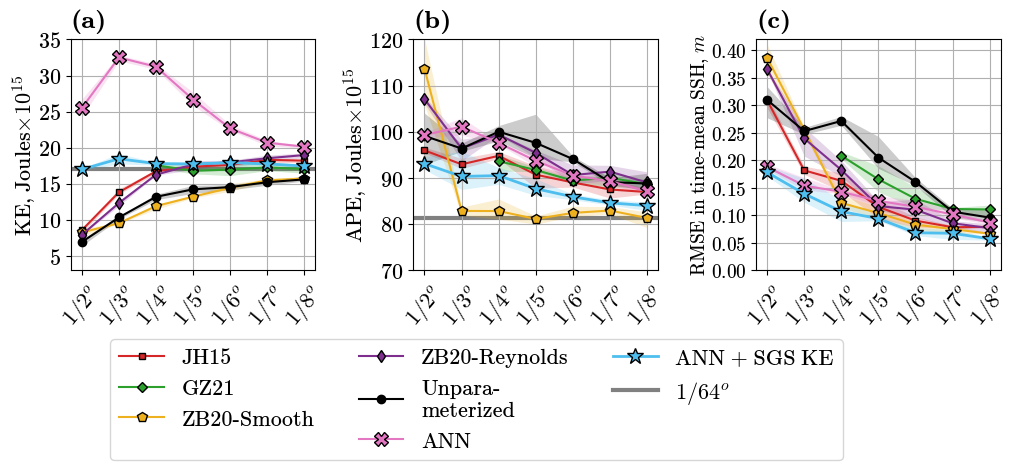

In [69]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(12,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun in enumerate([sample_KE, sample_APE, sample_ssh]):
    plt.subplot(1,3,row+1)
    error = {}
    error['bare'] = xr.concat([fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    #error['ZB-clean'] = xr.concat([fun(f'ZB-clean-{conf}-ZB-0.4', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Smooth'] = xr.concat([fun(f'ZB-Smooth-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Reynolds'] = xr.concat([fun(f'ZB-Reynolds-{conf}-ZB-2.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['Jansen-Held'] = xr.concat([fun(f'Jansen-Held-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['GZ'] = xr.concat([error['bare'].isel(res=0)*np.nan, error['bare'].isel(res=0)*np.nan] + [fun(f'{conf}_GZ-20YEAR', f'R64_{conf}') for conf in ['R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ANN'] = xr.concat([fun(f'ANN_CM26_grid_harmonic_ver3-{conf}-ZB-1.0-Cs-0.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ANN-SGS-KE'] = xr.concat([fun(f'ANN_CM26_grid_harmonic_ver3-{conf}-ZB-1.0-SGS-KE', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
        
    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None):
        error[model].mean('sample').plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw)
        plt.fill_between(range(7), error[model].min('sample'), error[model].max('sample'), color=color, alpha=0.2, lw=0)
    
    plot_markers_with_filling('Jansen-Held', 'tab:red', 's', 'JH15', 5)
    plot_markers_with_filling('GZ', 'tab:green', 'D', 'GZ21', 5)
    #plot_markers_with_filling('ZB-clean', 'tab:blue', 'o', 'ZB')
    plot_markers_with_filling('ZB-Smooth', yellow, 'p', 'ZB20-Smooth', 7)
    plot_markers_with_filling('ZB-Reynolds', violet, 'd', 'ZB20-Reynolds', 6)
    plot_markers_with_filling('bare', 'k', 'o', 'Unpara-\nmeterized', 6)
    plot_markers_with_filling('ANN', 'tab:pink', 'X', 'ANN', 10)
    plot_markers_with_filling('ANN-SGS-KE', lightblue, '*', 'ANN + SGS KE', 12, lw=2)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^o$', '$1/3^o$', '$1/4^o$', '$1/5^o$', '$1/6^o$', '$1/7^o$', '$1/8^o$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun == sample_KE:
        yticks = np.arange(5,40,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([3,35])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^o$', color='gray')
    if fun == sample_APE:
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun == sample_ssh:
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, $m$', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

plt.gcf().align_ylabels()
set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^o$')
plt.legend(ncol=3, bbox_to_anchor=(0.4,-0.25))

plt.savefig('../figures/Metrics-ANN-SGS-KE-full.pdf')

# Mean zonal acceleration

In [36]:
FGR=2.5
ds.remesh('R64', 'R4', f'R64_R4_FGR{FGR}', operator= lambda x,y: gaussian_remesh(x,y,FGR=FGR))
for file in [f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part1.nc', f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part2.nc']:
    dataset = xr.open_dataset(file, decode_times=False)
    for key in dataset.keys():
        setattr(ds[f'R64_R4_FGR{FGR}'], key, dataset[key])

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR2.5


In [53]:
def plot_accel(exp, x=True, y=True, vmax=1.5, zonal=True, zl=0, resolved='False'):
    accel = lambda x: 1e+7*x.sel(Time=slice(365*10,None)).mean('Time').isel(zl=zl).compute()
    
    if '_R' in exp:
        if zonal:
            field = ds[exp].SGSx
            field.loc[{'xq': slice(0,5), 'yh': slice(48,50)}] = 0.
        else:
            field = ds[exp].SGSy
            field.loc[{'xh': slice(0,5), 'yq': slice(48,50)}] = 0.
    elif 'GZ' in exp:
        if zonal:
            field = ds[exp].mom.CNNu+ds[exp].mom.diffu
        else:
            field = ds[exp].mom.CNNv+ds[exp].mom.diffv
    elif 'ANN' in exp:
        if zonal:
            field = ds[exp].mom.ZB2020u
        else:
            field = ds[exp].mom.ZB2020v
    else:
        if zonal:
            field = ds[exp].mom.diffu
        else:
            field = ds[exp].mom.diffv
            
    if resolved == 'True':
        field = ds[exp].advection[0]
    elif resolved == 'joint':
        field = field + ds[exp].advection[0]
            
    acceleration = accel(field)
    
    print(float(acceleration.min()),float(acceleration.max()))
    im = acceleration.plot.imshow(vmin=-vmax, vmax=vmax, add_colorbar=False, cmap='seismic', interpolation='none')

    if x:
        plt.xticks((0, 5, 10, 15, 20))
        plt.xlabel('Longitude')
    else:
        plt.xticks([])
        plt.xlabel('')
        
    if y:
        plt.yticks((30, 35, 40, 45, 50))
        plt.ylabel('Latitude')
    else:
        plt.yticks([])
        plt.ylabel('')
    plt.title('')    
    plt.gca().set_aspect(1)
    
    return im

In [54]:
coarse = 'R4'
hires = 'R64'
hires_bar = 'R64_R4'
ZB = 'ZB-clean-R4-ZB-0.5'
JansenHeld = 'Jansen-Held-R4-ref';
ZB_smooth = 'ZB-Smooth-R4-ZB-1.0'
ZB_reynolds = 'ZB-Reynolds-R4-ZB-2.0'
GZ = 'R4_GZ-20YEAR'

labeling = {
'coarse': '$1/4^o$',
'hires': '$1/64^o$',
'hires_bar': '$1/64^o$-Coarse',
'ZB': '$1/4^o$, ZB20',
'JansenHeld': '$1/4^o$, JH15',
'ZB_smooth': '$1/4^o$, ZB20-Smooth',
'ZB_reynolds': '$1/4^o$, ZB20-Reynolds',
'GZ': '$1/4^o$, GZ21'
}

-10.65854263305664 6.637511253356934
-8.378390357616551 4.449274736397129
-4.87225341796875 6.93408203125
-4.993709087371826 7.517899513244629
-8.812776565551758 8.217284202575684
-8.3770170211792 5.107608795166016
-7.559136867523193 2.3394572734832764
-10.127265930175781 3.883437156677246
Colorbar-like object skipped


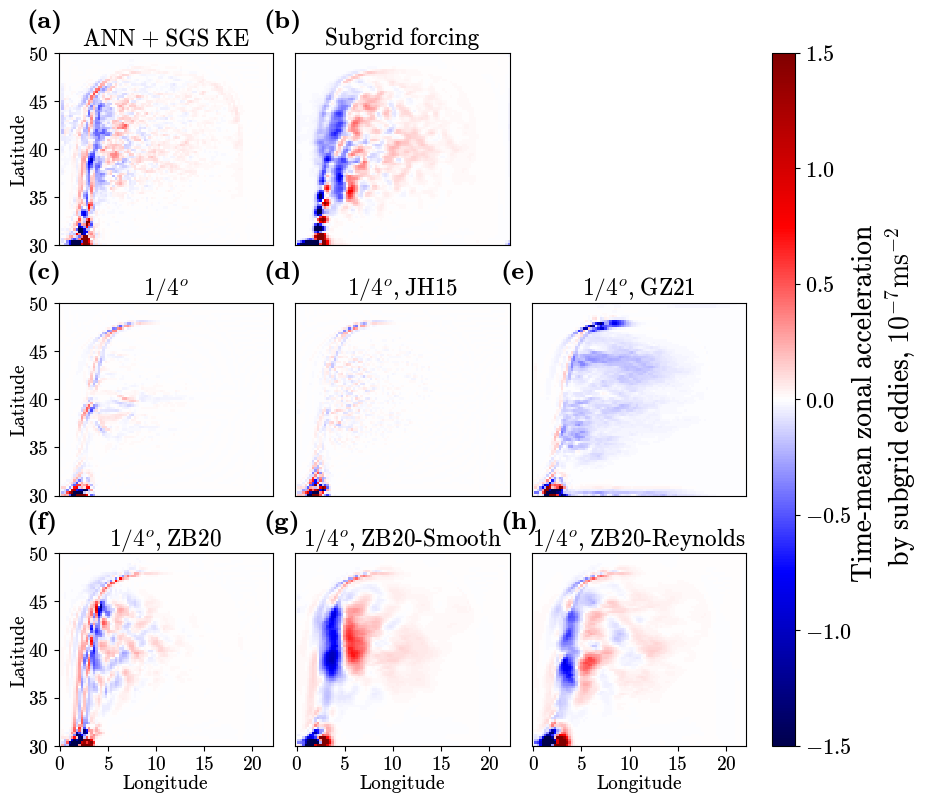

In [56]:
from matplotlib.patches import Rectangle
default_rcParams({'font.size': 14, 'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.3})
plt.figure(figsize = (11,9))

plt.subplot(3,3,1)
im=plot_accel('ANN_CM26_grid_harmonic_ver3-R4-ZB-1.0-SGS-KE',x=False)
#plt.title('Filtered and \ncoarsegrained $1/64^o$')
plt.title('ANN + SGS KE')


plt.subplot(3,3,2)
im=plot_accel('R64_R4_FGR2.5',x=False, y=False)
#plt.title('Filtered and \ncoarsegrained $1/64^o$')
plt.title('Subgrid forcing')


plt.subplot(3,3,4)
plot_accel(coarse, x=False)
plt.title(labeling['coarse'])
rect = Rectangle((2, 36), 5, 5, linewidth=3, edgecolor='tab:green', facecolor='none')
#plt.gca().add_patch(rect)

plt.subplot(3,3,5)
plot_accel(JansenHeld,x=False,y=False)
plt.title(labeling['JansenHeld'])

plt.subplot(3,3,6)
plot_accel(GZ,x=False,y=False)
plt.title(labeling['GZ'])

plt.subplot(3,3,7)
plot_accel(ZB)
plt.title(labeling['ZB'])

plt.subplot(3,3,8)
plot_accel(ZB_smooth,y=False)
plt.title(labeling['ZB_smooth'])
plt.xlabel('Longitude')

plt.subplot(3,3,9)
plot_accel(ZB_reynolds,y=False)
plt.title(labeling['ZB_reynolds'])
plt.xlabel('Longitude')

cb = plt.colorbar(im, ax=plt.gcf().axes, pad=0.03, aspect=30)
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Time-mean zonal acceleration \n by subgrid eddies, $10^{-7} \\mathrm{m}\\mathrm{s}^{-2}$', fontsize=20)#, labelpad=5)

set_letters(fontsize=18, y=1.13,x=-0.15)

#plt.savefig('Paper-Figures/zonal-acceleration-20.pdf')

Text(0.5, 1.03, 'Experiments at resolution $1/6^o$')

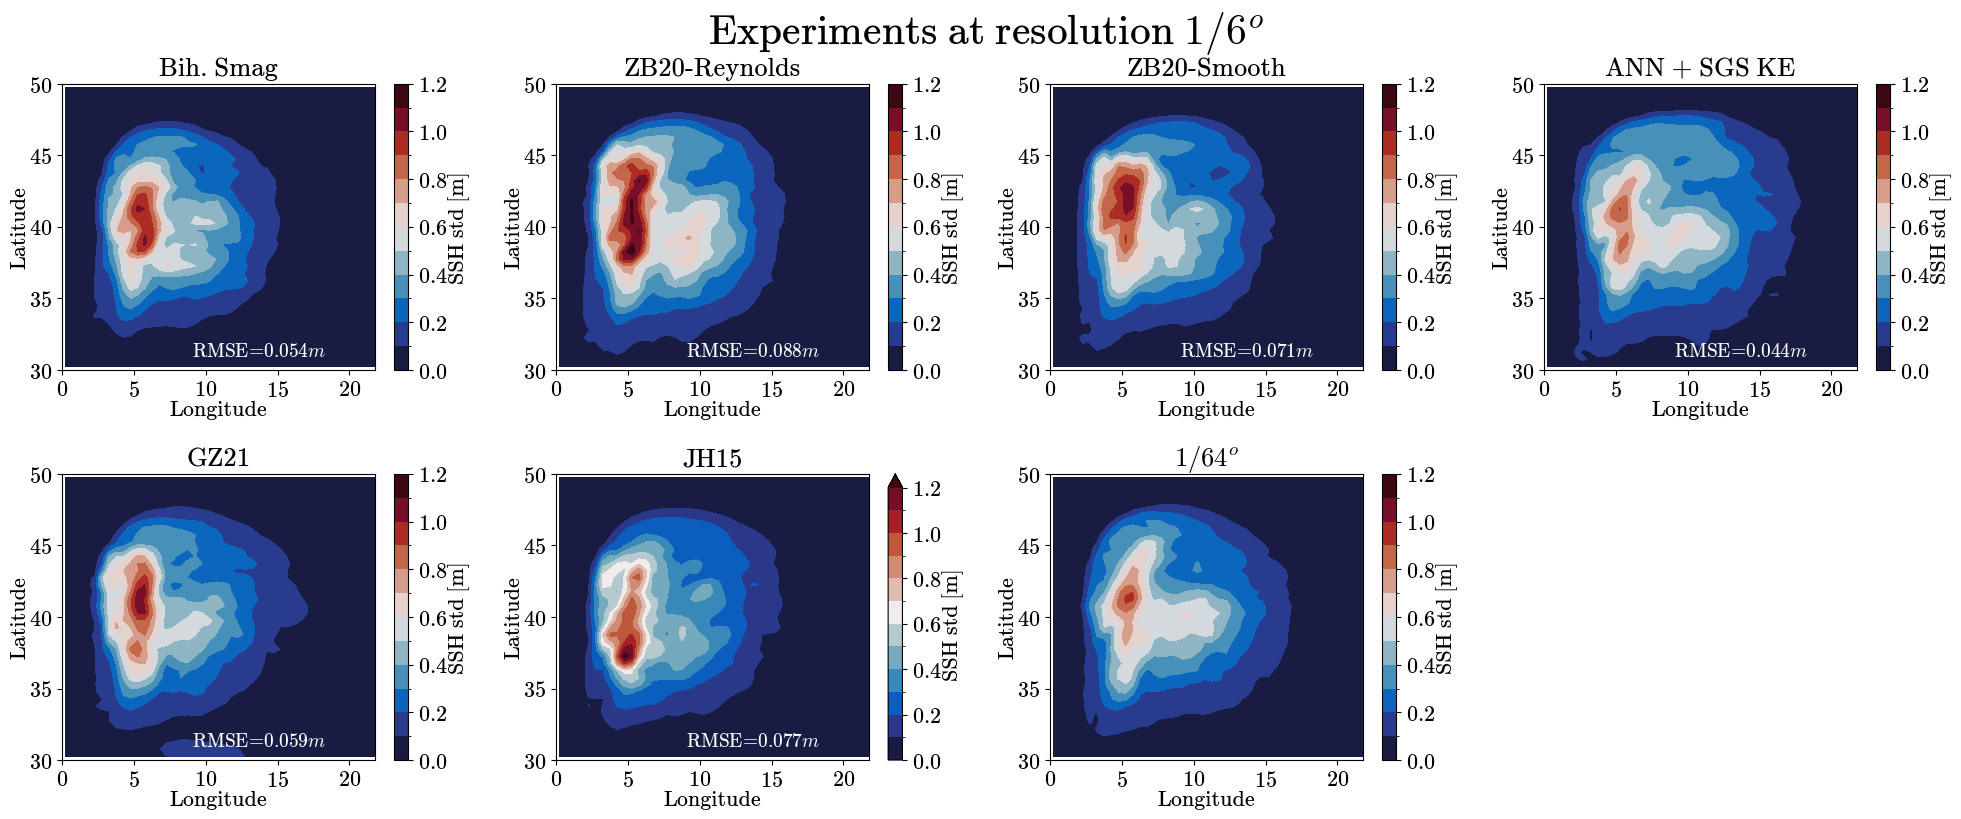

In [107]:
RR = 'R6'
ds.plot_ssh_std([f'{RR}', 
                 f'ZB-Reynolds-{RR}-ZB-2.0', 
                 f'ZB-Smooth-{RR}-ZB-1.0',
                 f'ANN_CM26_grid_harmonic_ver3-{RR}-ZB-1.0-SGS-KE', 
                 f'{RR}_GZ-20YEAR',
                 'Jansen-Held-R4-ref',
                 f'R64_{RR}'], 
                ['Bih. Smag', 
                 'ZB20-Reynolds', 
                 'ZB20-Smooth', 
                 'ANN + SGS KE', 
                 'GZ21',
                 'JH15',
                 '$1/64^o$'], ncols=4)
plt.suptitle('Experiments at resolution $1/6^o$', y=1.03, fontsize=30)

# Plotting NW2

In [4]:
import xarray as xr

In [5]:
import math
def x_coord(array):
    '''
    Returns horizontal coordinate, 'xq' or 'xh'
    as xarray
    '''
    try:
        coord = array.xq
    except:
        coord = array.xh
    return coord

def y_coord(array):
    '''
    Returns horizontal coordinate, 'yq' or 'yh'
    as xarray
    '''
    try:
        coord = array.yq
    except:
        coord = array.yh
    return coord

def remesh(input, target, fillna=True):
    '''
    Input and target should be xarrays of any type (u-array, v-array, q-array, h-array).
    Datasets are prohibited.
    Horizontal mesh of input changes according to horizontal mesh of target.
    Other dimensions are unchanged!

    If type of arrays is different:
        - Interpolation to correct points occurs
    If input is Hi-res:
        - Coarsening with integer grain and subsequent interpolation to correct mesh if needed
    if input is Lo-res:
        - Interpolation to Hi-res mesh occurs

    Input and output Nan values are treates as zeros (see "fillna")
    '''

    # Define coordinates
    x_input  = x_coord(input)
    y_input  = y_coord(input)
    x_target = x_coord(target)
    y_target = y_coord(target)

    # ratio of mesh steps
    ratiox = np.diff(x_target)[0] / np.diff(x_input)[0]
    ratiox = math.ceil(ratiox)

    ratioy = np.diff(y_target)[0] / np.diff(y_input)[0]
    ratioy = math.ceil(ratioy)
    
    # B.C.
    if fillna:
        result = input.fillna(0)
    else:
        result = input
    
    if (ratiox > 1 or ratioy > 1):
        # Coarsening; x_input.name returns 'xq' or 'xh'
        result = result.coarsen({x_input.name: ratiox, y_input.name: ratioy}, boundary='pad').mean()

    # Coordinate points could change after coarsegraining
    x_result = x_coord(result)
    y_result = y_coord(result)

    # Interpolate if needed
    if not x_result.equals(x_target) or not y_result.equals(y_target):
        result = result.interp({x_result.name: x_target, y_result.name: y_target})
        if fillna:
            result = result.fillna(0)

    # Remove unnecessary coordinates
    if x_target.name != x_input.name:
        result = result.drop_vars(x_input.name)
    if y_target.name != y_input.name:
        result = result.drop_vars(y_input.name)
    
    return result

In [12]:
R1_ann = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R1-ANN/CM26_grid_harmonic_ver3-SGS-KE/output/snapshots_00008010.nc', decode_times=False)

In [7]:
R2 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R2-long/bare/output/snapshots_00029020.nc', decode_times=False)
R2_ann = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R2-ANN/CM26_grid_harmonic_ver3-SGS-KE/output/snapshots_00029010.nc', decode_times=False)

In [8]:
R32f = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False).isel(xh=slice(None,None,8), yh=slice(None,None,8)).load()
def e_to_h(e, h):
    thickness = h * 0
    
    for zl in range(len(h.zl)):
        thickness[{'zl':zl}] = e.isel(zi=zl)-e.isel(zi=zl+1)
    
    return thickness

R32f['h'] = e_to_h(R32f.e, R32f.h).compute()

In [9]:
def KEz(ds):
    return 0.5 * (ds.h * (remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h))).sum('zl')

In [13]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.3, 'font.size': 14})
import matplotlib as mpl

def plot(idx=-1):
    plt.figure(figsize=(9,5))
    for col, (exp, label) in enumerate(
        zip(
        [R1_ann, R2_ann, R32f],
        ['$1^o$, ANN + SGS KE', '$1/2^o$, ANN + SGS KE', '$1/32^o$ filtered to $1^o$']
        )):
        plt.subplot(1,3,col+1)
        if col==2:
            _idx = idx % 4
        else:
            _idx = idx
            
        KE = KEz(exp.isel(time=_idx))
        im = KE.plot.imshow(
            norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
            cmap='inferno',
            add_colorbar=False,
            interpolation='none'
        )
        
        plt.gca().axes.set_aspect('equal')
        plt.xlabel('')
        plt.ylabel('')
        plt.title(label, fontsize=14)
        lons = [10,30,50]
        plt.xticks(lons, [f'${lon}^o$E' for lon in lons])
        if col==0:
            lats = [-60, -40, -20, 0, 20, 40, 60]
            lat_ticks = [f'${-lat}^o$S' if lat<0 else f'${lat}^o$N' for lat in lats]
            plt.yticks(lats, lat_ticks)
        else:
            plt.yticks([])

    plt.colorbar(im, pad=0.02, ax=plt.gcf().axes, extend='both', label='Depth-integrated KE, \n$\\frac{1}{2} \\sum_k h_k (u_k^2 + v_k^2)$, $\mathrm{m}^3/\mathrm{s}^2$')

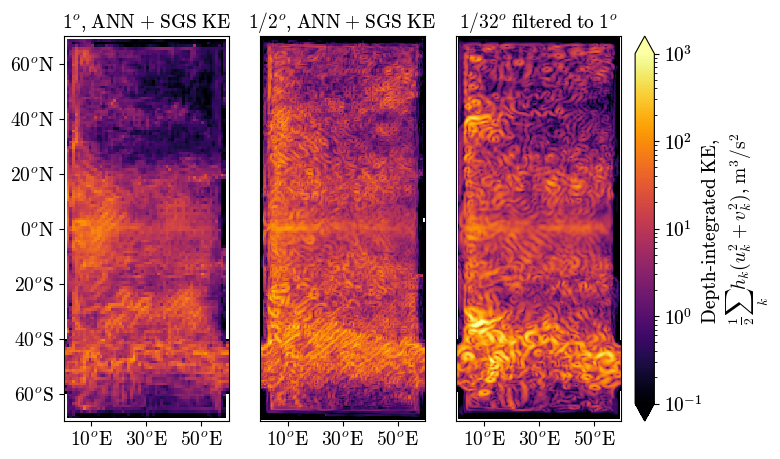

In [14]:
plot(0)

In [27]:
from helpers.plot_helpers import create_animation_ffmpeg
%time create_animation_ffmpeg(plot, range(33), FPS=15, filename='NW2_ANN_R2.mp4', dpi=100)

Native resolution of snapshots is used: 780x458

Animation NW2_ANN_R2.mp4 at FPS=15 will last for 2.2 seconds. The frames are saved to 
.ffmpeg/NW2_ANN_R2



ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

CPU times: user 41 s, sys: 22 s, total: 1min 2s
Wall time: 46.5 s


frame=   33 fps=0.0 q=-1.0 Lsize=    1139kB time=00:00:02.00 bitrate=4664.6kbits/s speed=7.15x    
video:1138kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.108935%
[libx264 @ 0x56463b658780] frame I:1     Avg QP:21.04  size: 78535
[libx264 @ 0x56463b658780] frame P:8     Avg QP:24.89  size: 29823
[libx264 @ 0x56463b658780] frame B:24    Avg QP:26.24  size: 35296
[libx264 @ 0x56463b658780] consecutive B-frames:  3.0%  0.0%  0.0% 97.0%
[libx264 @ 0x56463b658780] mb I  I16..4:  3.3% 58.4% 38.3%
[libx264 @ 0x56463b658780] mb P  I16..4:  0.2% 17.7%  5.3%  P16..4:  3.3%  5.5%  6.3%  0.0%  0.0%    skip:61.8%
[libx264 @ 0x56463b658780] mb B  I16..4:  0.1% 13.1%  6.2%  B16..8:  8.9% 10.2%  8.5%  direct: 5.4%  skip:47.7%  L0:35.6% L1:25.3% BI:39.1%
[libx264 @ 0x56463b658780] 8x8 transform intra:68.5% inter:52.6%
[libx264 @ 0x56463b658780] coded y,uvDC,uvAC intra: 92.1% 91.6% 91.5% inter: 27.7% 29.1% 27.1%
[libx264 @ 0x56463b658780] i16 v,h,dc,p: 89%  4%  7%  0%